# Purpose

The following error occurs when fitting canonical coherence for animal HPc, day 4, epoch 4:

> 2017-06-27 20:12:11,078 - src.analysis - INFO - ...saving canonical_coherence
  File "run_by_epoch.py", line 104, in main
    estimate_ripple_coherence(epoch_key)
  File "run_by_epoch.py", line 40, in estimate_ripple_coherence
    FREQUENCY_BANDS, multitaper_parameter_name=parameters_name)
  File "/projectnb/braincom/Jadhav-2016-Data-Analysis/src/analysis.py", line 130, in ripple_triggered_connectivity
    group_name)
  File "/projectnb/braincom/Jadhav-2016-Data-Analysis/src/analysis.py", line 199, in save_canonical_coherence
    tetrode_info.area.tolist())
  File "/projectnb/braincom/Jadhav-2016-Data-Analysis/src/spectral/connectivity.py", line 314, in canonical_coherence
    for label in labels]
  File "/projectnb/braincom/Jadhav-2016-Data-Analysis/src/spectral/connectivity.py", line 314, in <listcomp>
    for label in labels]
  File "/projectnb/braincom/Jadhav-2016-Data-Analysis/src/spectral/connectivity.py", line 941, in _normalize_fourier_coefficients
    _reshape(fourier_coefficients), full_matrices=False)
  File "/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/linalg/linalg.py", line 1359, in svd
    u, s, vt = gufunc(a, signature=signature, extobj=extobj)
  File "/usr3/graduate/edeno/.conda/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/numpy/linalg/linalg.py", line 99, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.linalg.LinAlgError: SVD did not converge


The purpose of this notebook is to figure out why the svd did not converge.

In [1]:
from copy import deepcopy
from functools import partial, wraps

import numpy as np
import pandas as pd
import xarray as xr

from src.parameters import MULTITAPER_PARAMETERS, SAMPLING_FREQUENCY, ANIMALS
from src.analysis import detect_epoch_ripples, _subtract_event_related_potential
from src.spectral.connectivity import Connectivity
from src.spectral.transforms import Multitaper
from src.data_processing import (get_LFP_dataframe, make_tetrode_dataframe, reshape_to_segments)

Let's run the code up to the point of failure

In [2]:
epoch_key = ('HPc', 4, 4)
multitaper_params = MULTITAPER_PARAMETERS['2Hz_Resolution']

In [3]:
ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
tetrode_info = tetrode_info[
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]

lfps = {tetrode_key: get_LFP_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in tetrode_info.index}

n_lfps = len(lfps)
n_pairs = int(n_lfps * (n_lfps - 1) / 2)
params = deepcopy(multitaper_params)
window_of_interest = params.pop('window_of_interest')
reshape_to_trials = partial(
    reshape_to_segments,
    sampling_frequency=params['sampling_frequency'],
    window_offset=window_of_interest, concat_axis=1)

ripple_locked_lfps = pd.Panel({
    lfp_name: _subtract_event_related_potential(
        reshape_to_trials(lfps[lfp_name], ripple_times))
    for lfp_name in lfps})

m = Multitaper(
    np.rollaxis(ripple_locked_lfps.values, 0, 3),
    **params,
    start_time=ripple_locked_lfps.major_axis.min())
c = Connectivity.from_multitaper(m)

Check the tetrodes to make sure there isn't any thing funny

In [5]:
tetrode_info

area  depth descrip  numcells animal  day  \
animal day epoch tetrode_number                                             
HPc    4   4     1               CA1    111  riptet         0    HPc    4   
                 2               CA1    103  riptet         5    HPc    4   
                 3               CA1     95  riptet         0    HPc    4   
                 4               CA1    109  riptet         2    HPc    4   
                 5               CA1     98  riptet         0    HPc    4   
                 6               CA1    110  riptet         7    HPc    4   
                 8               PFC     65     NaN         0    HPc    4   
                 9               PFC     60     NaN         0    HPc    4   
                 10              PFC     57     NaN         0    HPc    4   
                 11              PFC     81     NaN         0    HPc    4   
                 12              PFC     74     NaN         0    HPc    4   
                 13              PFC     99     NaN         0    HPc    4   
                 14              PFC     66     NaN         0    HPc    4   
                 15              PFC     71     NaN         7    HPc    4   
                 16              PFC     90     NaN         0    HPc    4   
                 18              Ctx    315     NaN         0    HPc    4   
                 19              Ctx    318     NaN         0    HPc    4   
                 20              Ctx    300     NaN         2    HPc    4   
                 21              Ctx    196     NaN         0    HPc    4   
                 22              Ctx      0     NaN         0    HPc    4   

                                 epoch  tetrode_number tetrode_id  
animal day epoch tetrode_number                                    
HPc    4   4     1                   4               1     HPc441  
                 2                   4               2     HPc442  
                 3                   4               3     HPc443  
                 4                   4               4     HPc444  
                 5                   4               5     HPc445  
                 6                   4               6     HPc446  
                 8                   4               8     HPc448  
                 9                   4               9     HPc449  
                 10                  4              10    HPc4410  
                 11                  4              11    HPc4411  
                 12                  4              12    HPc4412  
                 13                  4              13    HPc4413  
                 14                  4              14    HPc4414  
                 15                  4              15    HPc4415  
                 16                  4              16    HPc4416  
                 18                  4              18    HPc4418  
                 19                  4              19    HPc4419  
                 20                  4              20    HPc4420  
                 21                  4              21    HPc4421  
                 22                  4              22    HPc4422

In [6]:
ripple_locked_lfps.shape

(20, 2251, 219)

In [7]:
len(ripple_times)

219

In [8]:
tetrode_info.area.tolist()

['CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'CA1',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'Ctx',
 'Ctx',
 'Ctx',
 'Ctx',
 'Ctx']

Check the rest of the initial calculations before the SVD

In [9]:
group_labels = tetrode_info.area.tolist()
labels = np.unique(group_labels)
n_frequencies = c.fourier_coefficients.shape[-2]
non_negative_frequencies = np.arange(0, (n_frequencies + 1) // 2)
fourier_coefficients = c.fourier_coefficients[
            ..., non_negative_frequencies, :]

In [10]:
labels

array(['CA1', 'Ctx', 'PFC'], 
      dtype='<U3')

In [11]:
n_frequencies

750

In [12]:
non_negative_frequencies

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Check the fourier coefficients size and the indexing to find the non-negative frequencies

In [13]:
fourier_coefficients.shape

(3, 219, 1, 375, 20)

In [14]:
c.fourier_coefficients.shape

(3, 219, 1, 750, 20)

Everything seems fine. Now double check the function where the error is occuring.

In [16]:
from src.spectral.connectivity import _normalize_fourier_coefficients

normalized_fourier_coefficients = [
    _normalize_fourier_coefficients(
        fourier_coefficients[..., np.in1d(group_labels, label)])
    for label in labels]

LinAlgError: SVD did not converge

It still fails

In [48]:
label = 'PFC'
_normalize_fourier_coefficients(
        fourier_coefficients[..., np.in1d(group_labels, label)])

LinAlgError: SVD did not converge

Check selecting the tetrodes from the correct brain area

In [20]:
np.in1d(group_labels, label)

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=bool)

Check the fourier coefficients

In [22]:
fourier_coefficients[..., np.in1d(group_labels, label)]

array([[[[[             nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj],
          [             nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj],
          [             nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
                        nan            +nanj],
          ..., 
          [             nan            +nanj,
                        nan            +nanj,
                        nan            +nanj,
               

Check reshaping the fourier coefficients make sense

In [24]:
from src.spectral.connectivity import _reshape

f = fourier_coefficients[..., np.in1d(group_labels, label)]
print(f.shape)
print(_reshape(f).shape)

(3, 219, 1, 375, 6)
(3, 375, 6, 219)


It seems like there are lot of NaNs and this is the reason for the non-converngence

In [27]:
print(f.size)
print(np.isnan(f).sum())

1478250
4500


Let's try dropping the ripples with NaNs

In [30]:
ripple_locked_lfps

<class 'pandas.core.panel.Panel'>
Dimensions: 20 (items) x 2251 (major_axis) x 219 (minor_axis)
Items axis: (HPc, 4, 4, 1) to (HPc, 4, 4, 22)
Major_axis axis: -1.0 to 0.5
Minor_axis axis: (1, 9611.76533333, 9611.802, electric_potential) to (219, 10843.1706667, 10843.2133333, electric_potential)

In [33]:
ripple_locked_lfps.dropna(axis=2)

<class 'pandas.core.panel.Panel'>
Dimensions: 20 (items) x 2251 (major_axis) x 218 (minor_axis)
Items axis: (HPc, 4, 4, 1) to (HPc, 4, 4, 22)
Major_axis axis: -1.0 to 0.5
Minor_axis axis: (2, 9613.87933333, 9613.93066667, electric_potential) to (219, 10843.1706667, 10843.2133333, electric_potential)

Now we test if the canonical coherence works

In [45]:
m1 = Multitaper(
    np.rollaxis(ripple_locked_lfps.dropna(axis=2).values, 0, 3),
    **params,
    start_time=ripple_locked_lfps.major_axis.min())
c1 = Connectivity.from_multitaper(m1)

canonical_coherence, area_labels = c1.canonical_coherence(
        tetrode_info.area.tolist())

In [46]:
area_labels

array(['CA1', 'Ctx', 'PFC'], 
      dtype='<U3')

In [47]:
canonical_coherence.shape

(3, 375, 3, 3)

Now that we know it works, we want to figure out why there were so many NaNs for those particular ripples

In [88]:
bad_ripple = np.isnan(ripple_locked_lfps.values)

It seems like the culprit is the first ripple

In [95]:
np.any(np.any(bad_ripple, axis=0), axis=0)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

The first ripple starts within 1 second of the start of the recording session. Here's the start of the session.

In [106]:
lfps[('HPc', 4, 4, 14)].index[0]

9611.482

And this is the first detected ripple

In [101]:
ripple_times[0]

(9611.7653333333328, 9611.8019999999997)

All the NaNs occur at the beginning

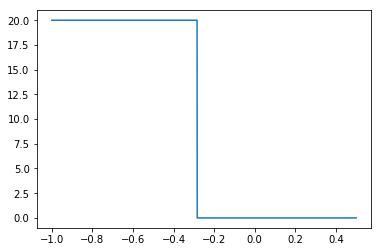

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(ripple_locked_lfps.major_axis, bad_ripple[:, :, 0].sum(axis=0));